## ポケモン使用率解析AI

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
# import time
import csv
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from pulp import *
import pandas as pd
import sys

In [2]:
MAX_RANK = 100  # 考える順位

In [3]:
 # ポケモンの順位と図鑑番号(URL)の配列取得
load_url = "https://sv.pokedb.tokyo/pokemon/list?season=1&rule=0"
html = requests.get(load_url)
soup = BeautifulSoup(html.content, "html.parser")

names = []
urls = []
i = 1
chap1 = soup.find(class_="columns is-mobile is-multiline")  # <div class="---" >
for chap2 in chap1.find_all("div"):  # <div data-pokemon-name="---">
    name = chap2.get('data-pokemon-name')
    names.append(name)

    url = chap2.find("a").get('href')  # <a href="---">
    urls.append(url)

    with open('home/url.csv', 'a') as f:
        f.write(url)
        f.write('\n')

    i += 1
    if i > MAX_RANK:  # 50位まで
        break

# print(names)  # 名前
print(urls)  # URL

['/pokemon/show/1000-00?season=1&rule=0', '/pokemon/show/0887-00?season=1&rule=0', '/pokemon/show/0635-00?season=1&rule=0', '/pokemon/show/0908-00?season=1&rule=0', '/pokemon/show/0149-00?season=1&rule=0', '/pokemon/show/0778-00?season=1&rule=0', '/pokemon/show/0479-02?season=1&rule=0', '/pokemon/show/0911-00?season=1&rule=0', '/pokemon/show/0445-00?season=1&rule=0', '/pokemon/show/0637-00?season=1&rule=0', '/pokemon/show/0983-00?season=1&rule=0', '/pokemon/show/0998-00?season=1&rule=0', '/pokemon/show/0184-00?season=1&rule=0', '/pokemon/show/0823-00?season=1&rule=0', '/pokemon/show/0934-00?season=1&rule=0', '/pokemon/show/0980-00?season=1&rule=0', '/pokemon/show/0977-00?season=1&rule=0', '/pokemon/show/0979-00?season=1&rule=0', '/pokemon/show/0462-00?season=1&rule=0', '/pokemon/show/0861-00?season=1&rule=0', '/pokemon/show/0970-00?season=1&rule=0', '/pokemon/show/0212-00?season=1&rule=0', '/pokemon/show/0700-00?season=1&rule=0', '/pokemon/show/0286-00?season=1&rule=0', '/pokemon/show/

In [4]:
 # 組み合わせポケモンの順位をcsvファイルに出力
urls = np.loadtxt('home/url.csv', dtype='unicode')[-MAX_RANK:]

for url in tqdm(urls):
    load_url = "https://sv.pokedb.tokyo"+url
    html = requests.get(load_url)
    soup = BeautifulSoup(html.content, "html.parser")

    j = 1
    same_names = []
    same_urls = []
    chap4 = soup.find(class_="table is-fullwidth is-narrow is-size-7 is-vertical-middle")  # <tr class="---"> 
    for chap5 in chap4.find_all("tr"):  # <tr>
        same_name = chap5.find("img").get('alt')  # <img alt="  " >
        same_names.append(same_name)

        same_url = chap5.find("a").get('href')  # <a href="  " >
        same_urls.append(same_url)

        j += 1
        if j > 10:  # 10番目まで
            break

    url_rank = {url: i for i, url in enumerate(urls)}  # URL:順位
    same_url_rank = [url_rank.get(url) for url in same_urls]
    same_url_rank = [rank if rank is not None else 150 for rank in same_url_rank]  # Noneを150に書き換え。順位がわからないポケモンは151位。

    with open('home/same_url_rank.csv', 'a') as f:
        w = csv.writer(f, lineterminator='\n')
        w.writerow(same_url_rank)
        # f.writelines(same_url_rank)  # 文字列に変更する必要あり。
        # f.write('\n')

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


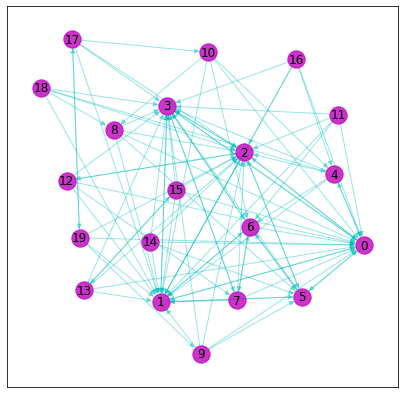

In [5]:
# とりあえず可視化
FIG_RANK = 20  # 表示するポケモンの順位
SAME_RANK = 5  # 表示する組み合わせの順位

data = np.loadtxt('home/same_url_rank.csv', delimiter=',').astype(np.int32)[-MAX_RANK:]

edges = []
for index in range(FIG_RANK):
    for same_index in range(SAME_RANK):
        rank = data[index, same_index]
        if rank < FIG_RANK:  # 50位以下は無視
            edge = [index, rank]
        edges.append(edge)
# print(edges)

G = nx.DiGraph()
plt.figure(figsize=(7, 7))
G.add_edges_from([(node0, node1) for node0, node1 in edges])

pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_color='m', alpha=0.8)
# nx.draw_networkx_labels(G, pos, name_dic)  # 文字化けが解消されない。
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color="c", alpha=0.4)
plt.show()

In [6]:
def _get_name(max_rank=MAX_RANK):  # 文字化けが解消されないので使っていない。
    urls = np.loadtxt('home/url.csv', dtype='unicode')[-MAX_RANK:]

    nums = []
    for i in range(MAX_RANK):
        if urls[i][20:21] == '0':
            if (int(urls[i][14:18])<1000):
                nums.append(urls[i][15:18])
            else:
                nums.append(urls[i][14:18])
        else:
            if (int(urls[i][14:18])<1000):
                nums.append(urls[i][15:19]+urls[i][20:21])
            else:
                nums.append(urls[i][14:19]+urls[i][20:21])
    # print(nums)

    df = pd.read_excel('home/poke_home.xlsx')  # デフォルトで1行飛ばす
    df = df.values
    num_name_dic = {str(num): name for num, name in df[:, :2]}
    # print(num_name_dic)
    names = [num_name_dic[num] for num in nums]
    name_dic = {i: name for i, name in enumerate(names[:max_rank])}
    # print(name_dic)
    return name_dic

In [7]:
def _pulp_init():  # pulpのための配列設定
    data = np.loadtxt('home/same_url_rank.csv', delimiter=',').astype(np.int32)[-MAX_RANK:]

    no_data = []  # dataにない組み合わせ。no_kumiで用いる。
    for i, data_ in enumerate(data):
        no_data_ = np.array(list(range(MAX_RANK)))
        no_data_ = np.setdiff1d(no_data_, data_)  # データの順位を削除
        no_data_ = np.setdiff1d(no_data_, i)  # そのもの順位を削除
        no_data.append(list(no_data_))
    # print(no_data)

    kumi = []
    for i in range(MAX_RANK):
        kumi_ = []
        for j in data[i]:
            if j < MAX_RANK:
                if i > j:
                    kumi_.append((j, i))
                else:
                    kumi_.append((i, j))
        kumi.append(kumi_)

    no_kumi = []
    for i in range(MAX_RANK):
        kumi_ = []
        for j in no_data[i]:
            if j < MAX_RANK:
                if i > j:
                    kumi_.append((j, i))
                else:
                    kumi_.append((i, j))
        no_kumi.append(kumi_)


    box_1 = np.array([[0]*MAX_RANK for _ in range(MAX_RANK)])
    for i in range(MAX_RANK):
        for j in range(i+1, MAX_RANK):
            box_1[i, j] = 2  # 解の合計が6を超えないように。組み合わせ使用率は2体が採用されるため、上三角は2。

    matrix_1 = np.zeros((MAX_RANK, MAX_RANK, MAX_RANK)).astype(np.int32)
    for i in range(MAX_RANK):
        for j in range(0, i):
            matrix_1[i, j, i] = 1
        for j in range(i+1, MAX_RANK):
            matrix_1[i, i, j] = 1  # それぞれ確率の合計が1を超えないように。またそもそもの順位を満たすように。

    # 使用数制限がある場合。
    # array_1 = np.load('home.npy')
    # array_1 = [x for x in array_1 if x < n]
    # box_2 = np.array([[0]*n for _ in range(n)])
    # for i in array_1:
    #     box_2[:, :] += matrix_1[i, :, :]

    return kumi, no_kumi, box_1, matrix_1

In [8]:
def rank_percent(a=0.4, b=0.575):  # 順位とクリック率を参考。累乗近似線。
    # a:一位の採用率
    # b:大きいほど高順位に集中
    # https://www.desmos.com/calculator/i7nmzt3sve?lang=ja
    # 一強環境a=0.75, b=0.71 バランス環境a=0.5, b=0.53 a=0.4, b=0.575
    x = np.array(list(range(1, MAX_RANK+1)))
    y = np.zeros((MAX_RANK))
    for i in range(MAX_RANK):
        y[i] = a*x[i]**(-b)
        # print(x[i], ':', y[i])

    print('yの合計:', np.sum(y))
    if np.sum(y) > 6:
        print('yの合計が6を超えてます')
        for b_pre in np.linspace(0, 1, 1000):
            for i in range(MAX_RANK):
                y[i] = a*x[i]**(-b_pre)
            if (np.sum(y)>5.8 and np.sum(y)<6):
                print('a:{}, b:{:.3f}, yの合計:{:.3}'.format(a, b_pre, np.sum(y)))
        sys.exit()

    return y


In [9]:
# pulpの条件設定
kumi, no_kumi, box_1, matrix_1 = _pulp_init()
f = rank_percent()

# 問題の定義
m = LpProblem(sense=LpMaximize)
x = [[LpVariable('x{}_{}'.format(i, j), lowBound=0, upBound=0.9, cat='Continuous')
    for j in range(MAX_RANK)]for i in range(MAX_RANK)]
y = LpVariable('y', lowBound=0, cat='Continuous')


# 目的関数
# m += lpDot(box_1, x)  # 採用率の最大
# m += y  # ばらつきの最大
m += lpDot(box_1, x) + y

# m += x[0][1]  # 最大を最大に
# m += x[n-2][n-1]  # 最小を最大に

# パーティは最大6体まで。3体で潜る人もいる。
# m += lpSum([x[i][j] for j in range(i+1, n)] for i in range(n)) <= 6
m += lpDot(box_1, x) <= 6
m += lpDot(box_1, x) >= 3

# 伝説の採用は2体まで
# m += lpDot(box_2, x) <= 2

# そもそもの使用率
for i in tqdm(range(MAX_RANK-1)):  # その他を例外する場合 --> MAX_RANK-2
    m += lpDot(matrix_1[i, :, :], x) >= lpDot(matrix_1[i+1, :, :], x)+y
    # m += lpDot(matrix_1[i, :, :], x) <= lpDot(matrix_1[i+1, :, :], x)+0.2
    m += lpDot(matrix_1[i, :, :], x) <= f[i]*1.25  # 累乗近似線との誤差、上の範囲
    m += lpDot(matrix_1[i, :, :], x) >= f[i]*0.75  # 下の範囲
m += lpDot(matrix_1[0, :, :], x) <= 1  # 1位の採用率は最大で1

# 一緒に組まれているポケモンの順位を考慮
for i in tqdm(range(MAX_RANK)):
    for j in range(len(kumi[i])-1):
        m += x[kumi[i][j][0]][kumi[i][j][1]] >= x[kumi[i][j+1][0]][kumi[i][j+1][1]]+y
        # m += x[kumi[i][j][0]][kumi[i][j][1]] <= x[kumi[i][j+1][0]][kumi[i][j+1][1]]+0.05
    # データにない組み合わせは全て10位以下
    index = len(kumi[i])-1
    for j in range(len(no_kumi[i])):
        m += x[kumi[i][index][0]][kumi[i][index][1]] >= x[no_kumi[i][j][0]][no_kumi[i][j][1]]+y


yの合計: 5.954157342370443


100%|██████████| 100/100 [00:00<00:00, 546.39it/s]


In [10]:
# plup実行！
m.solve(PULP_CBC_CMD(msg=False))

print('結果:', LpStatus[m.status])
print('目的関数:', value(m.objective))
print('yの値:', value(y))

kai = np.array([[0.0]*MAX_RANK for _ in range(MAX_RANK)])
for i in range(MAX_RANK):
    for j in range(MAX_RANK):
        if value(x[i][j]) is not None:
            kai[i, j] = value(x[i][j])  # i < j しか値が入っていない。
# print(kai)


for i in range(MAX_RANK):
    per = np.sum(matrix_1[i, :, :] * kai)  # 「LPdot」と「*」が同じ意味。「np.dot」は2次元以上だと行列の掛け算をする
    print('{:2d}:{:7.3f}%  合計値/理論値:{:.3f}'.format(i+1, per*100, per/f[i]))

print('その他:{:.3f}%'.format((6-np.sum(box_1 * kai))*100))

with open('home/solve.csv', 'w') as f:
    w = csv.writer(f, lineterminator='\n')
    w.writerows(kai)

結果: Optimal
目的関数: 6.000144854567854
yの値: 0.00014485388
 1: 32.005%  合計値/理論値:0.800
 2: 31.991%  合計値/理論値:1.191
 3: 26.584%  合計値/理論値:1.250
 4: 22.531%  合計値/理論値:1.250
 5: 19.818%  合計値/理論値:1.250
 6: 17.846%  合計値/理論値:1.250
 7: 16.332%  合計値/理論値:1.250
 8: 15.125%  合計値/理論値:1.250
 9: 14.135%  合計値/理論値:1.250
10: 13.304%  合計値/理論値:1.250
11: 12.594%  合計値/理論値:1.250
12: 11.980%  合計値/理論値:1.250
13: 11.441%  合計値/理論値:1.250
14: 10.963%  合計値/理論値:1.250
15: 10.537%  合計値/理論値:1.250
16: 10.139%  合計値/理論値:1.248
17:  9.117%  合計値/理論値:1.162
18:  9.103%  合計値/理論値:1.199
19:  8.394%  合計値/理論値:1.141
20:  8.380%  合計値/理論値:1.173
21:  8.365%  合計値/理論値:1.204
22:  6.409%  合計値/理論値:0.948
23:  6.395%  合計値/理論値:0.970
24:  6.189%  合計値/理論値:0.962
25:  6.174%  合計値/理論値:0.983
26:  6.160%  合計値/理論値:1.003
27:  6.145%  合計値/理論値:1.022
28:  6.131%  合計値/理論値:1.041
29:  6.116%  合計値/理論値:1.060
30:  6.102%  合計値/理論値:1.078
31:  6.087%  合計値/理論値:1.096
32:  5.112%  合計値/理論値:0.938
33:  5.097%  合計値/理論値:0.952
34:  5.083%  合計値/理論値:0.965
35:  4.424%  合計値/理論値:0.854


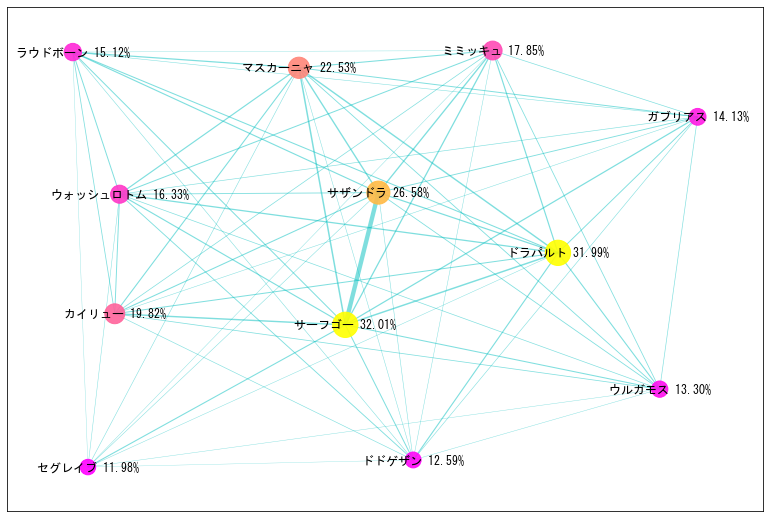

In [12]:
# ごりごりに可視化(50位まで)
EDGE_NUM = 65  # 組み合わせ上位oo位
NODE_NUM = 12  # ランキング上位oo位のみ表示
MIN_EDGE_NODE = 1  # 表示する最小エッジ数

data = np.loadtxt('home/solve.csv', delimiter=',')
# label = {i: i+1 for i in range(NODE_NUM)}
label = _get_name(max_rank=NODE_NUM)

_, _, _, matrix_1 = _pulp_init()
nodes = []
for i in range(NODE_NUM):
    per = np.sum(matrix_1[i, :, :] * data)
    nodes = np.append(nodes, (i, per))
    label[i] += ' {:.2f}%'.format(per*100)
    # print(label[i])
nodes = nodes.reshape(-1, 2)
# print(nodes[:10])


edges = []
for i in range(NODE_NUM):
    for j in range(i+1, NODE_NUM):
        edge = [i, j, data[i, j]]
        edges = np.append(edges, edge)
edges = edges.reshape(-1, 3)

max_index = np.argsort(edges[:, 2])[::-1]  # 重みの大きい順に表示
max_edges = np.array([[*edges[i, :]] for i in max_index])
max_edges = max_edges[:EDGE_NUM, :]
# print(max_edges[:50])

max_edges_flat = max_edges[:, :2].flatten()
edge_count = np.zeros(NODE_NUM)
for rank in max_edges_flat:
    edge_count[int(rank)] += 1
# print(edge_count)  # エッジカウンター
    

G = nx.Graph()
fig = plt.figure(figsize=(10.5, 7))
fig.add_axes((0, 0, 1, 1))  # 画面いっぱいに
G.add_nodes_from([(int(tag), {"weight":weight}) for tag, weight in nodes])
G.add_edges_from([(int(node0), int(node1), {"weight":weight}) for node0, node1, weight in max_edges])  # weightをオプションで指定

for i in range(NODE_NUM):
    if edge_count[i] < MIN_EDGE_NODE:
        G.remove_node(i)
        del label[i]


# グラフの描写
pos = nx.spring_layout(G, seed=2)
node_size = [d["weight"]*2000 for (n, d) in G.nodes(data=True)]
node_color = [d["weight"] for (n, d) in G.nodes(data=True)]  # 色は相対評価
# nx.draw_networkx_nodes(G, pos, node_color='m', alpha=0.9, node_size=node_size)
nx.draw_networkx_nodes(G, pos, node_color=node_color, alpha=0.9, node_size=node_size, cmap="spring")
nx.draw_networkx_labels(G, pos, label, font_family='MS Gothic')

# edge_width = [d["weight"]*200 for (u, v, d) in G.edges(data=True)]
edge_width = [d["weight"]**2*20000 for (u, v, d) in G.edges(data=True)]
# edge_color = [node_color[v] for (u, v, d) in G.edges(data=True)]
edge_color = [d["weight"]**5 for (u, v, d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, edge_color='c', alpha=0.5, width=edge_width)
# nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5, width=edge_width)
# plt.savefig('home/season1.png')
plt.show()